In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
from scipy import signal 
import holidays
from utils import *
from analysis import * 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [3]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


In [4]:
df = resampling_data(Electric, resample_cost='d')

df = df[~df.Load.isna()]
df

,Date,Hour,Minutes,Load,Day,Holiday,Day id
1,2008-01-02,11.5,22.5,1900414.4,2,False,2
2,2008-01-03,11.5,22.5,2023765.7,3,False,3
3,2008-01-04,11.5,22.5,2074081.7,4,False,4
4,2008-01-05,11.5,22.5,1910250.4,5,False,5
5,2008-01-06,11.5,22.5,1708630.0,6,False,6
...,...,...,...,...,...,...,...
3284,2016-12-28,11.5,22.5,1920741.9,2,False,363
3285,2016-12-29,11.5,22.5,1908350.9,3,False,364
3286,2016-12-30,11.5,22.5,1875408.2,4,False,365
3287,2016-12-31,11.5,22.5,1651508.7,5,False,366


In [5]:
df['Load_lin'] = linear_fit(x=df.index, y=df.Load)
df['Load_detrend'] = df.Load - df['Load_lin']

df.set_index('Date', inplace=True)
df

,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
Date,,,,,,,,
2008-01-02,11.5,22.5,1900414.4,2,False,2,1.651285e+06,249129.133128
2008-01-03,11.5,22.5,2023765.7,3,False,3,1.651331e+06,372435.015214
2008-01-04,11.5,22.5,2074081.7,4,False,4,1.651376e+06,422705.597300
2008-01-05,11.5,22.5,1910250.4,5,False,5,1.651422e+06,258828.879386
2008-01-06,11.5,22.5,1708630.0,6,False,6,1.651467e+06,57163.061472
...,...,...,...,...,...,...,...,...
2016-12-28,11.5,22.5,1920741.9,2,False,363,1.800392e+06,120349.621587
2016-12-29,11.5,22.5,1908350.9,3,False,364,1.800438e+06,107913.203674
2016-12-30,11.5,22.5,1875408.2,4,False,365,1.800483e+06,74925.085760


## Hourly Load Sum SARIMA Forecasting

In [6]:
hour_Load = df[['Load_detrend']].copy()
hour_Load

,Load_detrend
Date,
2008-01-02,249129.133128
2008-01-03,372435.015214
2008-01-04,422705.597300
2008-01-05,258828.879386
2008-01-06,57163.061472
...,...
2016-12-28,120349.621587
2016-12-29,107913.203674
2016-12-30,74925.085760


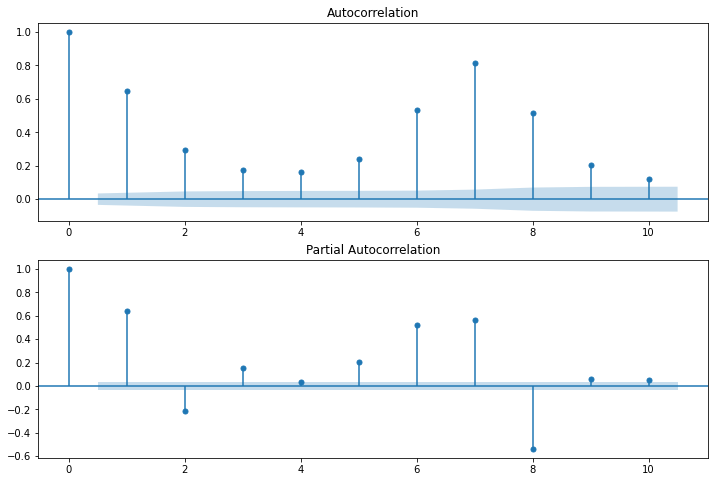

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
lag = 10
fig = sm.graphics.tsa.plot_acf(hour_Load, lags=lag, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hour_Load, lags=lag, ax=ax2)

In [8]:
sTest = StationarityTests()
sTest.kpss_Stationarity_Test(hour_Load['Load_detrend'])

sTest.Results

C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,KPSS Test Results
KPSS Test Statistic,0.303611
P-Value,0.1
# Lags Used,1
# Observations Used,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."
Critical Value (10%),0.347
Critical Value (5%),0.463
Critical Value (2.5%),0.574
Critical Value (1%),0.739
Is the time series stationary?,Yes


In [55]:
def sarimax_forecasting(df, feature='Load_detrend', cut_day='2016-12-22'):
    train_set = df[df.index <= pd.to_datetime(cut_day, format='%Y-%m-%d')]
    test_set = df[df.index >= pd.to_datetime(cut_day, format='%Y-%m-%d')]
    '''
    tmp = df[['Date', 'Load_lin', 'Load_detrend']].copy()
    n = len(forecasting) - len(test_set)

    tmp.loc[tmp.Date > cut_day,
            ['forecast', 'q1_forecast', 'q2_forecast']] = forecasting[:-n-1, :]
    tmp.set_index('Date', inplace=True)'''
    
    # (4,0,5) x (1,1,0,7)
    # (8,0, 30) x (1, 1, 1, 24)
    model = SARIMAX(train_set, order=(4,0,5), seasonal_order=(1,1,0,7))
    results = model.fit()

    return results


def save_sarimax_results(forecast, original_df):   
    df = forecast.conf_int().copy()
    original_df = original_df[original_df.index >= df.index[0]].copy()
    
    df['mean Load'] = df.mean(axis=1)
    df['Load_lin'] = original_df.Load_lin
    n_days = (pd.to_datetime(df.index[-1]) - pd.to_datetime(df.index[0])).days
    df.to_csv(f"../Results/SARIMAX/Sarimax_results_{n_days}days.csv")

In [10]:
cut_dates = ['2016-12-22', '2016-12-01', '2016-11-01']

C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\cosmi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'

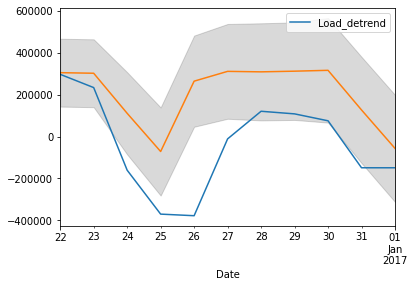

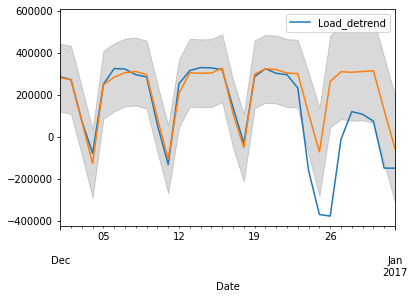

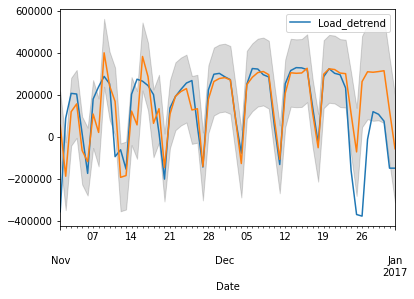

In [56]:
for date in cut_dates:
    results = sarimax_forecasting(hour_Load, date)

    forecast = results.get_prediction(start=pd.to_datetime(date, format='%Y-%m-%d'),
                                    end=hour_Load.index[-1])

    hour_Load.iloc[-len(forecast.conf_int()):].plot()
    forecast.predicted_mean.plot()
    plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Load_detrend'], 
                    forecast.conf_int()['upper Load_detrend'], color='k', alpha=0.15)
    
    save_sarimax_results(forecast, df)